# Hyper-parameter Investigation

Hyper-parameters to be investigated: <br>
1. Number of hidden layers <br>
2. Number of nodes per layer <br>
3. The type of activation function used in each layer <br>
4. The learning rate <br>
5. The number of epochs <br>

Baseline parameters used for the network (unless otherwise specified):
- Leaky ReLU activation function for hidden layers
- Sigmoid activation function for the output layer 
- A single training cycle consists of 2000 epochs 
- Default learning rate is 0.05

## Setup

In [1]:
import time
import funcs
import network as net
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

**Step 1:** Get the data 

In [2]:
# The input data (each row is an instance)
data = pd.read_csv("data_banknote_authentication.txt",
    sep=",",
    header=None,
)
x = data.iloc[:, 0:3].to_numpy()
y = data.iloc[:, 4].to_numpy()

**Step 2:** Method for initiating and training the network

In [3]:
def train_nn(nr_layers, nr_nodes, activation_func, learning_rate, nr_epochs):
    layers = []
    for i in range(nr_layers):
        layers.append(net.layer(nr_nodes, activation_func))
    layers.append(net.layer(1, funcs.sigmoid)) # add the output layer with sigmoid as activation func
    
    n = net.network(x, layers, y, alpha=learning_rate)
    
    start_time = time.time()
    acc, loss  = n.train(nr_epochs)
    t_time = time.time() - start_time # training time

    return acc, loss, t_time

## 1. Number of hidden layers

Investigate the accuracy of neural networks with varying numbers of hidden layers (0 to 10). To isolate the effect of the number of hidden layers on a network's performance, each layer has a single nodes. Performance metrics used to evaluate the model are - average accuracy, loss and training time calculated form 10 trial runs of the model.

**Step 1:** Train the network and collect the performance metrics

In [4]:
epochs = 2000
nr_reps = 3
nr_models = 5

accuracy_layers = np.zeros(( nr_models, epochs))
loss_layers =  np.zeros(( nr_models, epochs))
t_time_layers = np.zeros(( nr_models, nr_reps))

# for each set of hyperparameters investigated, re-train the network a set number of times
for i in range (nr_reps):
    for j in range(nr_models):
        an, ln, tn = train_nn(j, 1, funcs.leaky_relu, 0.05, 2000)

        # Averaging as we go via weighted sum
        accuracy_layers[j] += an / nr_reps
        loss_layers[j] += ln / nr_reps
        t_time_layers[j] += tn / nr_reps

**Step 2:** Plot the performance metrics 

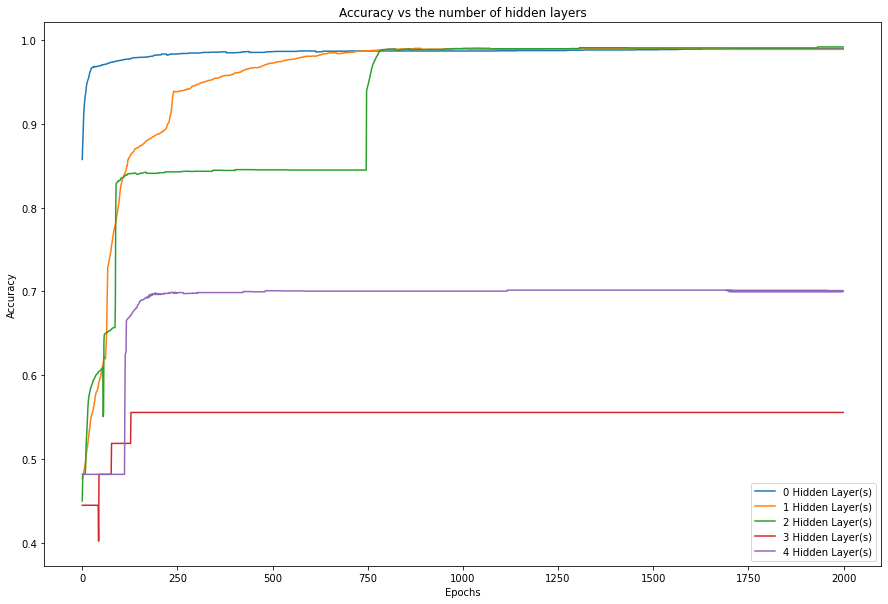

In [5]:
plt.figure(figsize=(15, 10))
for i in range(accuracy_layers.shape[0]):
    plt.plot(accuracy_layers[i], linestyle = 'solid', label = f'{i} Hidden Layer(s)')
    
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy vs the number of hidden layers')
plt.legend(loc=4)
plt.show()

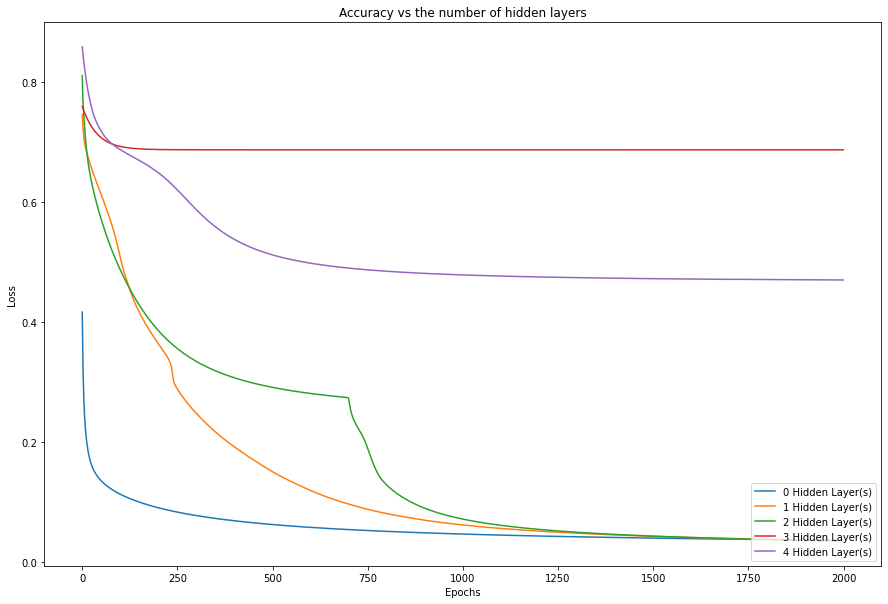

In [6]:
plt.figure(figsize=(15, 10))
for i in range(loss_layers.shape[0]):
    plt.plot(loss_layers[i], linestyle = 'solid', label = f'{i} Hidden Layer(s)')
    
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Accuracy vs the number of hidden layers')
plt.legend(loc=4)
plt.show()

## 2. Number of nodes per layer

Next, investigate the effect of the number of nodes per layer on a network's performance. In the previous experiment networks with 2, 4, and 6 hidden layers performed best (**perhaps this is not the best way to reason about this, the accuracy in the previous section changes dramatically from run to run, as well if the activation is changed**), therefore these architectures will be used as baseline and the number of nodes altered (exclude networks with single node per layer as this scenario was explored in the previous section).  

#### 2.1. Train the model

In [7]:
epochs = 2000
nr_reps = 3
nr_models = 4

accuracy_nodes = np.zeros(( nr_models, epochs))
loss_nodes =  np.zeros(( nr_models, epochs))
t_time_nodes = np.zeros(( nr_models, nr_reps))

# for each set of hyperparameters investigated, re-train the network a set number of times
for i in range (nr_reps):
    for j in range(nr_models):
        an, ln, tn = train_nn(2, j+2, funcs.leaky_relu, 0.05, 2000)

        # Averaging as we go via weighted sum
        accuracy_nodes[j] += an / nr_reps
        loss_nodes[j] += ln / nr_reps
        t_time_nodes[j] += tn / nr_reps

#### 2.2. Plot the performance metrics

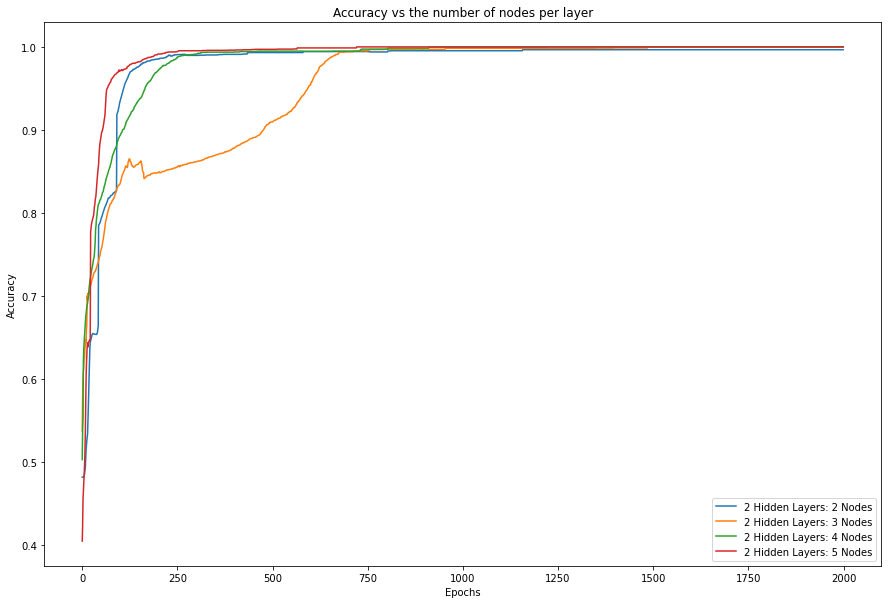

In [8]:
plt.figure(figsize=(15, 10))

for i in range(accuracy_nodes.shape[0]):
    plt.plot(accuracy_nodes[i], linestyle = 'solid', label = f'2 Hidden Layers: {i+2} Nodes')
    
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy vs the number of nodes per layer')
plt.legend(loc=4)
plt.show()

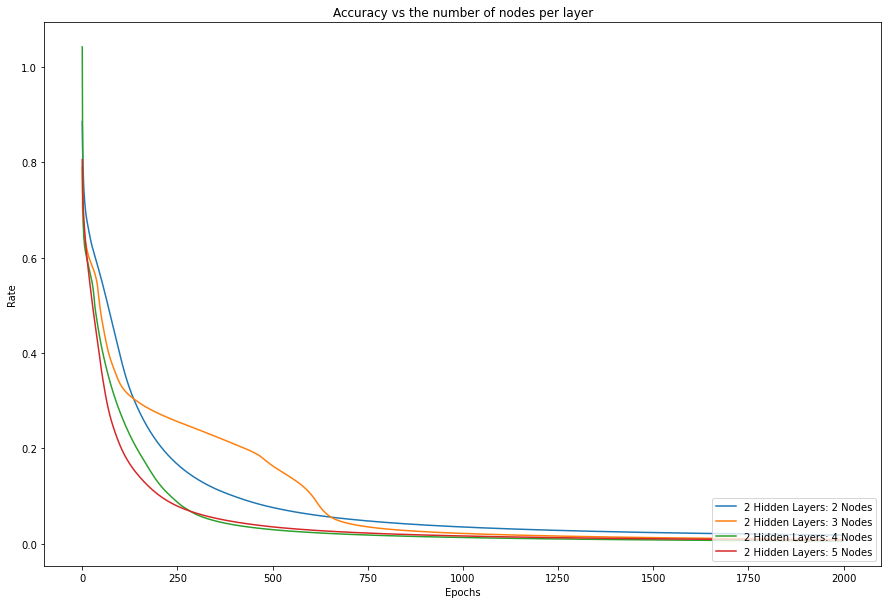

In [9]:
plt.figure(figsize=(15, 10))
for i in range(loss_nodes.shape[0]):
    plt.plot(loss_nodes[i], linestyle = 'solid', label = f'2 Hidden Layers: {i+2} Nodes')
    
plt.xlabel('Epochs')
plt.ylabel('Rate')
plt.title('Accuracy vs the number of nodes per layer')
plt.legend(loc=4)
plt.show()

## 3. Type of activation function

Explore the effect of activation function used in the hidden layers on the model's performance. For the final output to be in the range between 0 and 1 (necessary to evaluate the model's performance using the loss function), sigmoid activation function is used in the output layer.
Activation functions used:
- Logistic activation function (**sigmoid**)
- Hyperbolic tangent activation function (**tanh**)
- Rectified Linear Unit activation function (**relu**)
- Leaky ReLU activation function (**leaky_relu**)

#### 3.1. Train the model

In [10]:
epochs = 2000
nr_reps = 3
nr_models = 4

accuracy_func = np.zeros(( nr_models, epochs))
loss_func =  np.zeros(( nr_models, epochs))
t_time_func = np.zeros(( nr_models, nr_reps))

activation_funcs = [funcs.sigmoid, funcs.tanh, funcs.relu, funcs.leaky_relu]
# for each set of hyperparameters investigated, re-train the network a set number of times
for i in range (nr_reps):
    for j in range(nr_models):
        an, ln, tn = train_nn(2, 5, activation_funcs[j], 0.05, 2000)

        # Averaging as we go via weighted sum
        accuracy_func[j] += an / nr_reps
        loss_func[j] += ln / nr_reps
        t_time_func[j] += tn / nr_reps

#### 3.2. Plot the performance metrics

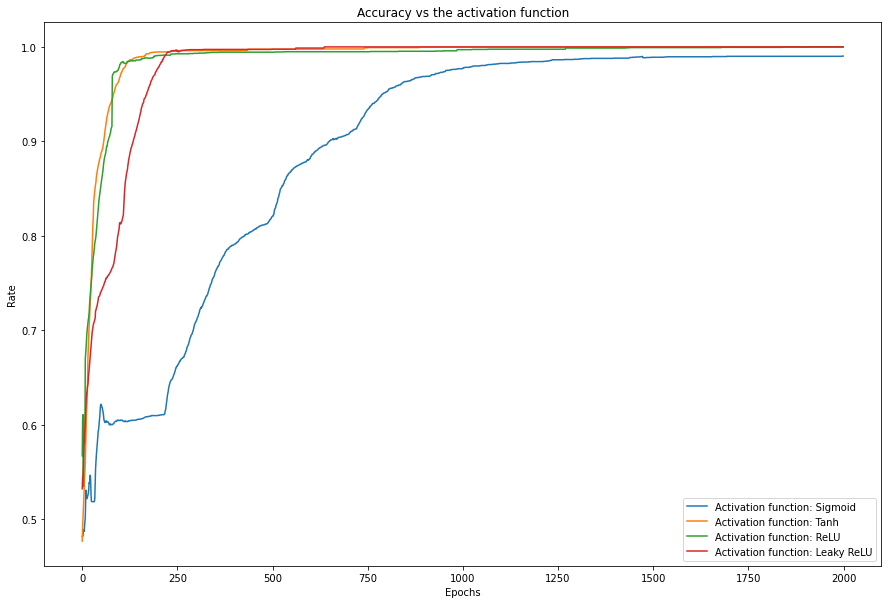

In [11]:
funcs_names = ["Sigmoid", "Tanh", "ReLU", "Leaky ReLU"]
plt.figure(figsize=(15, 10))
for i in range(accuracy_func.shape[0]):
    plt.plot(accuracy_func[i], linestyle = 'solid', label = f'Activation function: {funcs_names[i]}')
    
plt.xlabel('Epochs')
plt.ylabel('Rate')
plt.title('Accuracy vs the activation function')
plt.legend(loc=4)
plt.show()

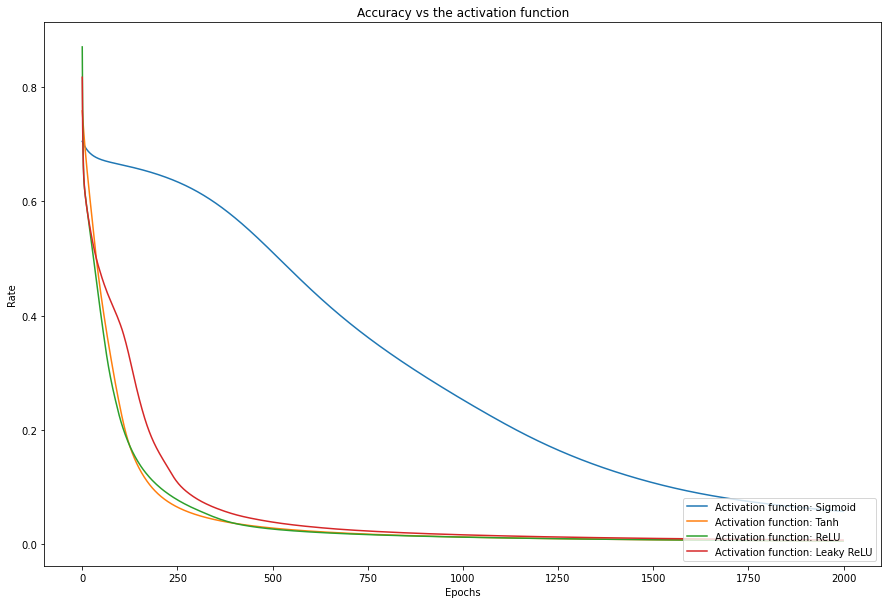

In [12]:
funcs_names = ["Sigmoid", "Tanh", "ReLU", "Leaky ReLU"]
plt.figure(figsize=(15, 10))
for i in range(loss_func.shape[0]):
    plt.plot(loss_func[i], linestyle = 'solid', label = f'Activation function: {funcs_names[i]}')
    
plt.xlabel('Epochs')
plt.ylabel('Rate')
plt.title('Accuracy vs the activation function')
plt.legend(loc=4)
plt.show()

## 4. Learning rate 

Baseline architecture of the network used: 2 hidden layers with 5 nodes per layer, leaky ReLU activation func for hidden layers. <br>
1. Find the threshold value for the learning rate, i.e., the largest possible value (approximately) for which loss of the model decreases in the first ~30 epochs. The initial values tested are as follows: 2.5, 1.5, 1.0, 0.5, 0.1, 0.05

In [13]:
epochs = 30
nr_reps = 10
nr_models = 3

accuracy_alpha = np.zeros(( nr_models, epochs))
loss_alpha =  np.zeros(( nr_models, epochs))
t_time_alpha = np.zeros(( nr_models, nr_reps))

learning_rate = [0.3, 0.1, 0.05]

# for each set of hyperparameters investigated, re-train the network a set number of times
for i in range (nr_reps):
    for j in range(nr_models):
        an, ln, tn = train_nn(2, 5, funcs.leaky_relu, learning_rate[j], epochs)

        # Averaging as we go via weighted sum
        accuracy_alpha[j] += an / nr_reps
        loss_alpha[j] += ln / nr_reps
        t_time_alpha[j] += tn / nr_reps

/disk1/code/uni/f21bc-cw/funcs.py:42: RuntimeWarning: divide by zero encountered in log
  c = np.log(1 - y_hat)
/disk1/code/uni/f21bc-cw/funcs.py:43: RuntimeWarning: invalid value encountered in multiply
  return -(a + b * c)
/disk1/code/uni/f21bc-cw/funcs.py:47: RuntimeWarning: divide by zero encountered in true_divide
  return (y_hat - y) / (y_hat - y_hat**2)
/disk1/code/uni/f21bc-cw/funcs.py:47: RuntimeWarning: invalid value encountered in true_divide
  return (y_hat - y) / (y_hat - y_hat**2)
/disk1/code/uni/f21bc-cw/network.py:97: RuntimeWarning: invalid value encountered in multiply
  dL_dz = layer.act.der(layer.z) * dL_da
/disk1/code/uni/f21bc-cw/funcs.py:11: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-z))
/disk1/code/uni/f21bc-cw/funcs.py:40: RuntimeWarning: divide by zero encountered in log
  a = y * np.log(y_hat)
/disk1/code/uni/f21bc-cw/funcs.py:40: RuntimeWarning: invalid value encountered in multiply
  a = y * np.log(y_hat)


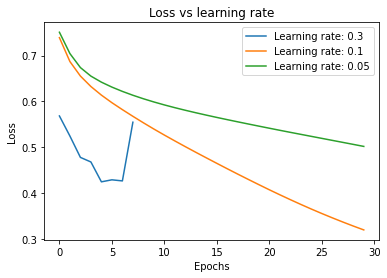

In [14]:
for i in range(loss_alpha.shape[0]):
    plt.plot(loss_alpha[i], linestyle = 'solid', label = f'Learning rate: {learning_rate[i]}')
    
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss vs learning rate')
plt.legend(loc=1)
plt.show()

#### 4.1. Train the model

In [15]:
epochs = 2000
nr_reps = 3
nr_models = 5

accuracy_alpha = np.zeros(( nr_models, epochs))
loss_alpha =  np.zeros(( nr_models, epochs))
t_time_alpha = np.zeros(( nr_models, nr_reps))

learning_rate = [0.1, 0.05, 0.01, 0.005, 0.001]

# for each set of hyperparameters investigated, re-train the network a set number of times
for i in range (nr_reps):
    for j in range(nr_models):
        an, ln, tn = train_nn(2, 5, funcs.relu, learning_rate[j], 2000)

        # Averaging as we go via weighted sum
        accuracy_alpha[j] += an / nr_reps
        loss_alpha[j] += ln / nr_reps
        t_time_alpha[j] += tn / nr_reps

#### 4.2. Plot the performance metrics

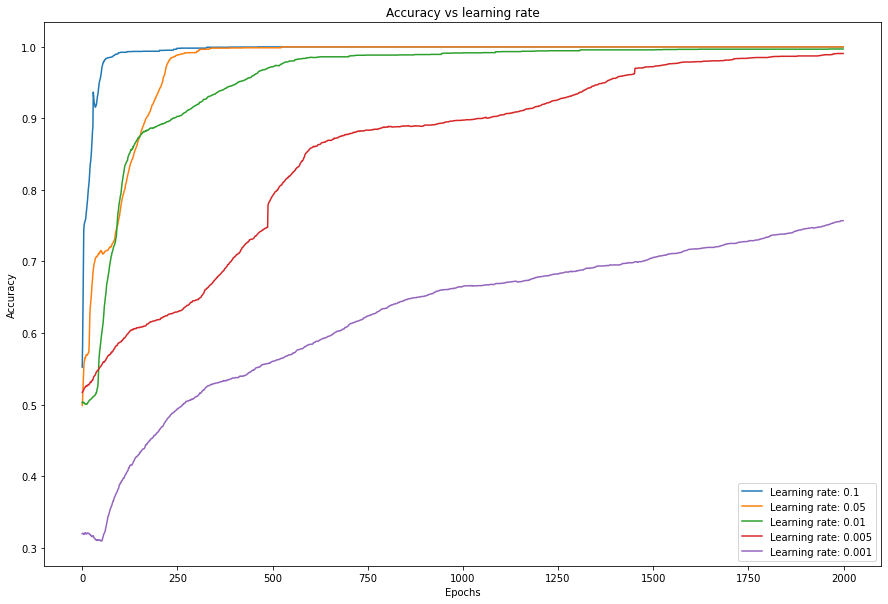

In [16]:
plt.figure(figsize=(15, 10))

for i in range(accuracy_alpha.shape[0]):
    plt.plot(accuracy_alpha[i], linestyle = 'solid', label = f'Learning rate: {learning_rate[i]}')
    
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy vs learning rate')
plt.legend(loc=4)
plt.show()

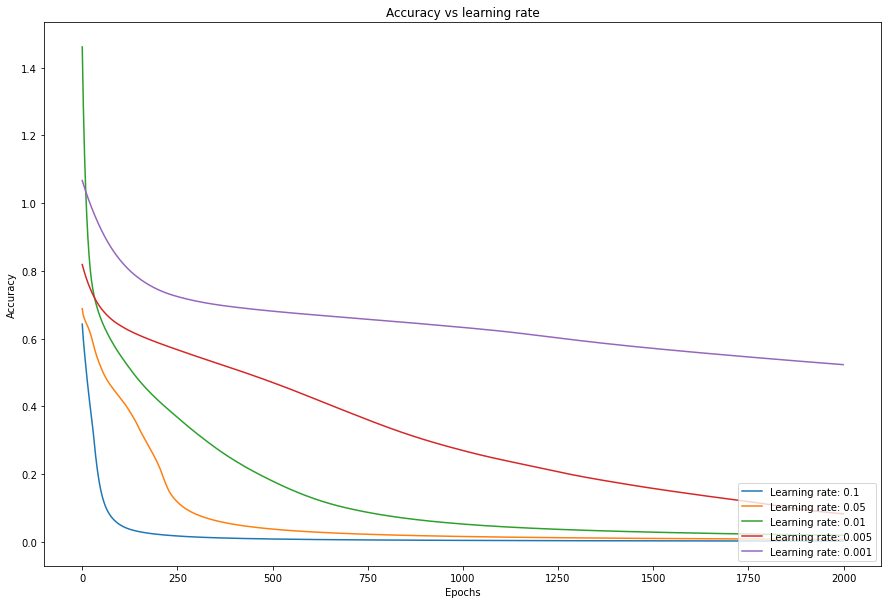

In [17]:
plt.figure(figsize=(15, 10))

for i in range(accuracy_alpha.shape[0]):
    plt.plot(loss_alpha[i], linestyle = 'solid', label = f'Learning rate: {learning_rate[i]}')
    
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy vs learning rate')
plt.legend(loc=4)
plt.show()

## 5. Number of epochs

#### 5.1. Train the models

In [18]:
def train_nn_epochs(epochs):
    nr_reps = 3
    nr_models = 2

    acc = np.zeros((nr_models, epochs))
    loss =  np.zeros((nr_models, epochs))
    t_time = np.zeros((nr_models, nr_reps))

    learning_rate = [0.05, 0.001]

    # for each set of hyperparameters investigated, re-train the network a set number of times
    for _ in range (nr_reps):
        for j in range(nr_models):
            an, ln, tn = train_nn(2, 5, funcs.relu, learning_rate[j], epochs)

            # Averaging as we go via weighted sum
            acc[j] += an / nr_reps
            loss[j] += ln / nr_reps
            t_time[j] += tn / nr_reps
    
    return acc, loss, t_time

In [19]:
acc4000, loss4000, t_time4000 = train_nn_epochs(4000)
acc6000, loss6000, t_time6000 = train_nn_epochs(6000)
acc8000, loss8000, t_time8000 = train_nn_epochs(8000)
acc10000, loss10000, t_time10000 = train_nn_epochs(10000)

/disk1/code/uni/f21bc-cw/funcs.py:42: RuntimeWarning: divide by zero encountered in log
  c = np.log(1 - y_hat)
/disk1/code/uni/f21bc-cw/funcs.py:43: RuntimeWarning: invalid value encountered in multiply
  return -(a + b * c)
/disk1/code/uni/f21bc-cw/funcs.py:47: RuntimeWarning: invalid value encountered in true_divide
  return (y_hat - y) / (y_hat - y_hat**2)


#### 5.2. Plot the performance metrics

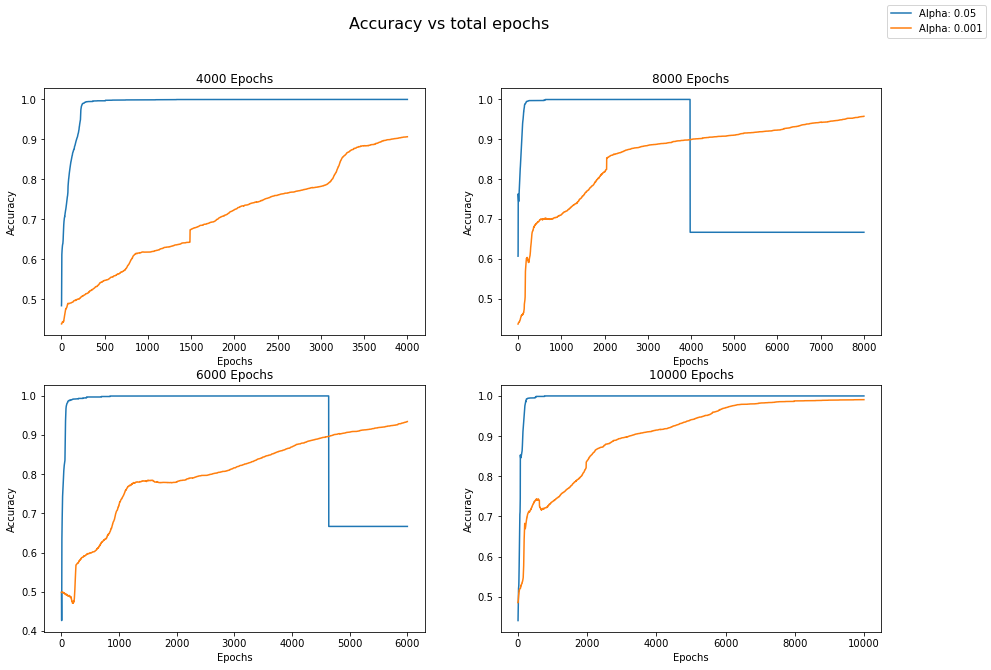

In [20]:
fig, axs = plt.subplots(2, 2, figsize=(15, 10))

learning_rate = [0.05, 0.001]

for i in range(acc4000.shape[0]):
    axs[0, 0].plot(acc4000[i], label=f'Alpha: {learning_rate[i]}')
    axs[0, 1].plot(acc8000[i])
    axs[1, 0].plot(acc6000[i])
    axs[1, 1].plot(acc10000[i])

axs[0, 0].set_title('4000 Epochs')
axs[0, 1].set_title('8000 Epochs')
axs[1, 0].set_title('6000 Epochs')
axs[1, 1].set_title('10000 Epochs')

fig.suptitle("Accuracy vs total epochs", fontsize=16)
fig.legend()

for ax in axs.flat:
    ax.set(xlabel='Epochs', ylabel='Accuracy')

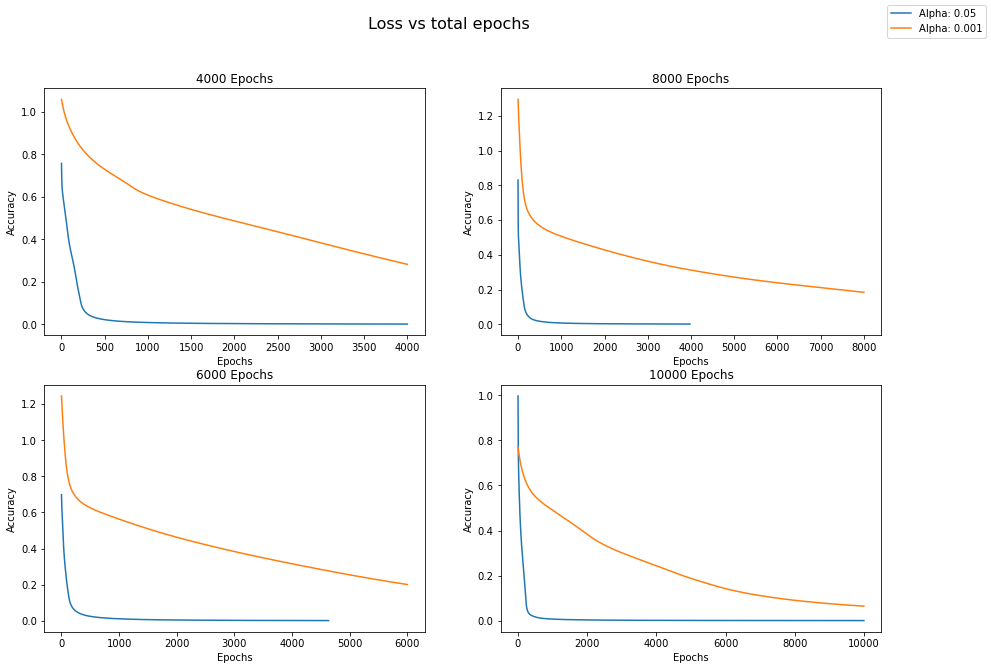

In [21]:
fig, axs = plt.subplots(2, 2, figsize=(15, 10))

learning_rate = [0.05, 0.001]

for i in range(loss4000.shape[0]):
    axs[0, 0].plot(loss4000[i], label=f'Alpha: {learning_rate[i]}')
    axs[0, 1].plot(loss8000[i])
    axs[1, 0].plot(loss6000[i])
    axs[1, 1].plot(loss10000[i])

axs[0, 0].set_title('4000 Epochs')
axs[0, 1].set_title('8000 Epochs')
axs[1, 0].set_title('6000 Epochs')
axs[1, 1].set_title('10000 Epochs')

fig.suptitle("Loss vs total epochs", fontsize=16)
fig.legend()

for ax in axs.flat:
    ax.set(xlabel='Epochs', ylabel='Accuracy')

# Boxplots

The results in this plot make no sense, but perhaps could be useful to present data in this way.